# Task 4: The Turing Test
## Genetic Algorithm Attack on AI Text Detector

**Objective**: Use evolutionary algorithms to evolve AI-generated text that bypasses the detector.

**Parts**:
1. **Super-Imposter**: GA-based adversarial attack (5-10 generations)
2. **Personal Test**: Analyze user-provided text and attempt manual/automated evasion

**Key Constraints**:
- No retraining of the detector
- Simple, interpretable GA implementation
- LLM-as-Mutator approach

---

## 1. Setup & Imports

In [2]:
# Core imports
import json
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

# Transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Google Gemini (optional - fallback to mock if unavailable)
try:
    import google.generativeai as genai
    GEMINI_AVAILABLE = True
except:
    GEMINI_AVAILABLE = False
    print("  Google Gemini needs to be set")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_LENGTH = 256

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"✓ Imports complete")
print(f"Device: {device}")
print(f"Gemini available: {GEMINI_AVAILABLE}")

✓ Imports complete
Device: cpu
Gemini available: True


---
## 2. Load Trained Detector Model

In [3]:
import os

IN_KAGGLE = os.path.exists('/kaggle/input')

if IN_KAGGLE:
    MODEL_PATH = Path('/kaggle/input/tier-c-lora-model/tier_c_lora_model')
else:
    MODEL_PATH = Path('../output/tier_c_models/tier_c_lora_model')

print(f"Loading model from: {MODEL_PATH}")

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH,
    num_labels=2
)
model.to(device)
model.eval()

print("✓ Detector model loaded successfully!")

Loading model from: /kaggle/input/tier-c-lora-model/tier_c_lora_model


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

2026-02-07 12:08:12.625096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770466092.887072      94 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770466092.963688      94 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770466093.605309      94 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770466093.605391      94 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770466093.605395      94 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Detector model loaded successfully!


---
## 3. Detector Interface Function

In [4]:
def detect_text(text: str) -> Dict[str, float]:
    """
    Classify text as Human or AI-generated.
    
    Args:
        text: Input paragraph
    
    Returns:
        Dict with 'human_prob', 'ai_prob', 'prediction' (0=Human, 1=AI)
    """
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=MAX_LENGTH,
        padding='max_length'
    )
    
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
    
    return {
        'human_prob': float(probs[0]),
        'ai_prob': float(probs[1]),
        'prediction': int(np.argmax(probs)),
        'label': 'Human' if np.argmax(probs) == 0 else 'AI'
    }

# Test the detector
test_text = "The old man walked slowly down the street, his cane tapping rhythmically."
result = detect_text(test_text)
print(f"Test detection:")
print(f"  Human probability: {result['human_prob']:.2%}")
print(f"  AI probability: {result['ai_prob']:.2%}")
print(f"  Prediction: {result['label']}")
print("\n✓ Detector interface ready")

Test detection:
  Human probability: 99.75%
  AI probability: 0.25%
  Prediction: Human

✓ Detector interface ready


---
## 4. LLM Generation Interface (with Mock Fallback)

In [24]:
import os
import google.generativeai as genai
from kaggle_secrets import UserSecretsClient

# Read API key from Kaggle Secrets - THE CORRECT WAY
user_secrets = UserSecretsClient()
try:
    GEMINI_API_KEY = user_secrets.get_secret("GEMINI_API_KEY")
    GEMINI_AVAILABLE = True
except:
    GEMINI_API_KEY = None
    GEMINI_AVAILABLE = False

if GEMINI_AVAILABLE:
    genai.configure(api_key=GEMINI_API_KEY)
    gemini_model = genai.GenerativeModel("gemini-3-flash-preview")
    print("✓ Gemini API detected and configured")
else:
    gemini_model = None
    print("⚠ Gemini API key not found - using mock generation")

✓ Gemini API detected and configured


In [6]:
def generate_text(prompt: str, use_mock: bool = False) -> str:
    """
    Generate text using Gemini or mock generation.
    
    Args:
        prompt: Generation prompt
        use_mock: If True, use mock generation (for demo purposes)
    
    Returns:
        Generated text
    """
      
    # if 'rewrite' in prompt.lower() or 'alter' in prompt.lower():
    #     # Return a slightly modified version
    #     base_idx = hash(prompt) % len(mock_responses['initial'])
    #     base_text = mock_responses['initial'][base_idx]
    #     # Simulate mutation by swapping words
    #     words = base_text.split()
    #     if len(words) > 10:
    #         # Swap a few words
    #         idx1, idx2 = hash(prompt) % (len(words)-1), (hash(prompt)+1) % (len(words)-1)
    #         words[idx1], words[idx2] = words[idx2], words[idx1]
    #     return ' '.join(words)
    # else:
    #     # Initial generation
    #     idx = hash(prompt) % len(mock_responses['initial'])
    #     return mock_responses['initial'][idx]
    # else:
    #     # Real Gemini generation
    try:
        response = gemini_model.generate_content(prompt)
        return response.text
    except Exception as e:
        print(f"Gemini error: {e}")
        return "Error generating text"

# Test generation
test_gen = generate_text("Write a paragraph about AI")
print(f"Test generation (first 150 chars):\n{test_gen[:150]}...\n")
print("✓ Text generation ready")

Test generation (first 150 chars):
Artificial intelligence (AI) is a rapidly evolving field of computer science focused on creating systems capable of performing tasks that typically re...

✓ Text generation ready


---
## 5. Genetic Algorithm Implementation

### 5.1 GA Helper Functions

In [7]:
def evaluate_population(population: List[str]) -> List[Dict]:
    """
    Evaluate fitness of all individuals in population.
    
    Fitness = Human probability (higher is better for evasion)
    
    Args:
        population: List of text paragraphs
    
    Returns:
        List of dicts with text, scores, and fitness
    """
    evaluated = []
    
    for text in population:
        result = detect_text(text)
        evaluated.append({
            'text': text,
            'fitness': result['human_prob'],  # Fitness = Human probability
            'human_prob': result['human_prob'],
            'ai_prob': result['ai_prob'],
            'label': result['label']
        })
    
    # Sort by fitness (descending)
    evaluated.sort(key=lambda x: x['fitness'], reverse=True)
    
    return evaluated


def select_top_k(evaluated_population: List[Dict], k: int = 3) -> List[str]:
    """
    Select top k individuals by fitness.
    
    Args:
        evaluated_population: List of evaluated individuals
        k: Number to select
    
    Returns:
        List of top k text strings
    """
    return [ind['text'] for ind in evaluated_population[:k]]


def mutate_population(parents: List[str], target_size: int = 10) -> List[str]:
    """
    Generate mutated variants using LLM-as-Mutator.
    
    Mutation strategies:
    1. Alter sentence rhythm
    2. Introduce grammatical irregularity
    3. Reduce polish / add inconsistency
    
    Args:
        parents: List of parent texts
        target_size: Desired population size
    
    Returns:
        New population (parents + mutated children)
    """
    mutation_prompts = [
        "Rewrite this paragraph to alter sentence rhythm while keeping vocabulary mostly intact: {}",
        "Introduce a subtle grammatical irregularity or rare/archaic phrasing into this paragraph: {}",
        "Reduce polish and introduce slight inconsistency in tone for this paragraph: {}",
        "Rewrite with more natural, conversational flow: {}",
        "Add subtle imperfections and vary sentence structure: {}"
    ]
    
    new_population = parents.copy()  # Keep parents (elitism)
    
    mutations_needed = target_size - len(parents)
    
    for i in range(mutations_needed):
        # Select random parent
        parent = parents[i % len(parents)]
        
        # Select random mutation strategy
        prompt_template = mutation_prompts[i % len(mutation_prompts)]
        prompt = prompt_template.format(parent)
        
        # Generate mutated variant
        mutated = generate_text(prompt)
        new_population.append(mutated)
    
    return new_population


print(" GA functions defined")

 GA functions defined


### 5.2 Main GA Loop

In [8]:
def run_genetic_algorithm_with_checkpointing(
    initial_population: List[str],
    num_generations: int = 10,
    population_size: int = 10,
    selection_size: int = 3,
    target_fitness: float = 0.90,
    verbose: bool = True,
    checkpoint_file: str = 'ga_checkpoint.pkl',
    resume_from_checkpoint: bool = False
) -> Dict:
    """
    Run genetic algorithm with automatic checkpointing.
    Can resume from checkpoint after rate limit errors.
    
    Args:
        initial_population: Starting population
        num_generations: Maximum generations
        population_size: Size of population
        selection_size: Number of top individuals to keep
        target_fitness: Stop if best fitness exceeds this
        verbose: Print progress
        checkpoint_file: Where to save progress
        resume_from_checkpoint: If True, load from checkpoint
    
    Returns:
        Dict with history, best individual, etc.
    """
    
    # Try to resume from checkpoint
    if resume_from_checkpoint:
        try:
            with open(checkpoint_file, 'rb') as f:
                checkpoint = pickle.load(f)
            
            population = checkpoint['population']
            history = checkpoint['history']
            start_gen = checkpoint['last_generation'] + 1
            
            if verbose:
                print(f" RESUMING FROM CHECKPOINT")
                print(f"   Last completed generation: {checkpoint['last_generation']}")
                print(f"   Continuing from generation: {start_gen}")
                print(f"   Population size: {len(population)}\n")
        except FileNotFoundError:
            if verbose:
                print(f"  No checkpoint found. Starting fresh.\n")
            resume_from_checkpoint = False
    
    # Initialize fresh if not resuming
    if not resume_from_checkpoint:
        population = initial_population[:population_size]
        history = {
            'best_fitness': [],
            'avg_fitness': [],
            'worst_fitness': [],
            'best_individual': [],
            'generation': []
        }
        start_gen = 0
    
    if verbose and start_gen == 0:
        print("="*80)
        print("GENETIC ALGORITHM: SUPER-IMPOSTER EVOLUTION")
        print("="*80)
        print(f"Population size: {population_size}")
        print(f"Selection size: {selection_size}")
        print(f"Max generations: {num_generations}")
        print(f"Target fitness (Human prob): {target_fitness:.1%}\n")
    
    # Main GA loop
    for gen in range(start_gen, num_generations):
        if verbose:
            print(f"\n{'─'*80}")
            print(f"GENERATION {gen + 1}/{num_generations}")
            print(f"{'─'*80}")
        
        try:
            # Evaluate population
            evaluated = evaluate_population(population)
            
            # Track metrics
            best = evaluated[0]
            avg_fit = np.mean([ind['fitness'] for ind in evaluated])
            worst_fit = evaluated[-1]['fitness']
            
            history['best_fitness'].append(best['fitness'])
            history['avg_fitness'].append(avg_fit)
            history['worst_fitness'].append(worst_fit)
            history['best_individual'].append(best['text'])
            history['generation'].append(gen + 1)
            
            if verbose:
                print(f"\nFitness Statistics:")
                print(f"  Best:  {best['fitness']:.2%} (Human prob) - Label: {best['label']}")
                print(f"  Avg:   {avg_fit:.2%}")
                print(f"  Worst: {worst_fit:.2%}")
                print(f"\nBest Individual (first 200 chars):")
                print(f"  {best['text'][:200]}...")
            
            # Save checkpoint after successful generation
            checkpoint = {
                'population': evaluated,  # Save evaluated population with fitness scores
                'history': history,
                'last_generation': gen,
                'timestamp': datetime.now().isoformat()
            }
            
            with open(checkpoint_file, 'wb') as f:
                pickle.dump(checkpoint, f)
            
            if verbose:
                print(f"\n Checkpoint saved (generation {gen + 1})")
            
            # Check stopping criterion
            if best['fitness'] >= target_fitness:
                if verbose:
                    print(f"\n{'='*80}")
                    print(f" TARGET REACHED! Best fitness {best['fitness']:.2%} >= {target_fitness:.1%}")
                    print(f"{'='*80}")
                break
            
            # Selection
            parents = select_top_k(evaluated, k=selection_size)
            
            if verbose:
                print(f"\nSelected {len(parents)} parents for reproduction")
            
            # Mutation for next generation
            if gen < num_generations - 1:
                if verbose:
                    print(f"Generating {population_size - len(parents)} mutated offspring...")
                
                # parents already contains text strings from select_top_k
                population = mutate_population(parents, target_size=population_size)
        
        except Exception as e:
            # If rate limit hit, save checkpoint and exit gracefully
            if "429" in str(e) or "quota" in str(e).lower():
                print(f"\n  RATE LIMIT HIT at generation {gen + 1}")
                print(f" Progress saved to {checkpoint_file}")
                print(f"\n To resume, run:")
                print(f"   results = run_genetic_algorithm_with_checkpointing(")
                print(f"       initial_population,")
                print(f"       resume_from_checkpoint=True")
                print(f"   )")
                
                # Save what we have so far
                checkpoint = {
                    'population': population,
                    'history': history,
                    'last_generation': gen - 1,  # Last completed generation
                    'timestamp': datetime.now().isoformat(),
                    'error': str(e)
                }
                
                with open(checkpoint_file, 'wb') as f:
                    pickle.dump(checkpoint, f)
                
                return {
                    'history': history,
                    'checkpoint_saved': True,
                    'last_generation': gen - 1,
                    'resume_available': True
                }
            else:
                # Some other error
                raise e
    
    # Final results
    final_evaluated = evaluate_population(population)
    best_final = final_evaluated[0]
    
    return {
        'history': history,
        'best_individual': best_final,
        'final_population': final_evaluated,
        'generations_run': len(history['generation']),
        'completed': True
    }


# ============================================================================
# STEP 2: Helper Function to Check Checkpoint Status
# ============================================================================

def check_checkpoint_status(checkpoint_file='ga_checkpoint.pkl'):
    """Check what's in the checkpoint file"""
    try:
        with open(checkpoint_file, 'rb') as f:
            checkpoint = pickle.load(f)
        
        print("="*80)
        print("CHECKPOINT STATUS")
        print("="*80)
        print(f"Last completed generation: {checkpoint['last_generation']}")
        print(f"Population size: {len(checkpoint['population'])}")
        print(f"Saved at: {checkpoint['timestamp']}")
        
        if 'history' in checkpoint:
            history = checkpoint['history']
            if history['best_fitness']:
                print(f"\nBest fitness so far: {max(history['best_fitness']):.2%}")
                print(f"Generations completed: {len(history['generation'])}")
        
        if 'error' in checkpoint:
            print(f"\nStopped due to: {checkpoint['error'][:100]}...")
        
        print("\n Ready to resume!")
        print("="*80)
        
        return True
    except FileNotFoundError:
        print(" No checkpoint found.")
        return False

---
## 6. Part 1: Run the Super-Imposter Attack

### 6.1 Generate Initial Population

In [9]:
# Generate 10 initial AI paragraphs on a common theme
print("Generating initial population of AI-written paragraphs...\n")

initial_prompts = [
    "Write a paragraph about artificial intelligence and its impact on society",
    "Write a paragraph about AI and technology advancement",
    "Write a paragraph about machine learning applications",
    "Write a paragraph about AI in modern business",
    "Write a paragraph about AI and scientific research",
    "Write a paragraph about AI's role in automation",
    "Write a paragraph about computational intelligence",
    "Write a paragraph about AI and data analysis",
    "Write a paragraph about AI technologies and innovation",
    "Write a paragraph about AI systems and efficiency"
]

initial_population = [generate_text(prompt) for prompt in initial_prompts]

print(f" Generated {len(initial_population)} paragraphs\n")
print("Sample from initial population:")
print(f"  {initial_population[0][:200]}...")

Generating initial population of AI-written paragraphs...

 Generated 10 paragraphs

Sample from initial population:
  Artificial intelligence is rapidly transforming society, offering unprecedented opportunities for progress and innovation while simultaneously raising complex ethical and societal questions. From auto...


### 6.2 Run GA Evolution

In [ ]:
import pickle
import json
from datetime import datetime
# Run the genetic algorithm
# ga_results = run_genetic_algorithm_with_checkpointing(
#     initial_population,
#     num_generations=6,
#     population_size=10,
#     resume_from_checkpoint=False  # Start fresh
# )

In [51]:

current_generation = 6 # ← Change this to 2, 3, 4, 5, 6 for each run
population_size = 10
selection_size = 3
# AUTO-CONNECT: Automatically uses output from previous generation

# Initialize storage on first run
if 'generation_storage' not in locals():
    generation_storage = {}
    print("✓ Initialized generation storage\n")

# Get current population based on generation number
if current_generation == 1:
    # Generation 1: use initial population
    current_population = initial_population
    print(" Using initial population\n")
else:
    # Generation 2+: use output from previous generation
    prev_gen = current_generation - 1
    if prev_gen in generation_storage:
        current_population = generation_storage[prev_gen]
        print(f" Loaded population from Generation {prev_gen}\n")
    else:
        print(f"  ERROR: Generation {prev_gen} output not found!")
        print(f"   Run Generation {prev_gen} first, then come back to this.\n")
        raise ValueError(f"Must run Generation {prev_gen} before Generation {current_generation}")

# ──────────────────────────────────────────────────────────────────────────
# PROCESS GENERATION
# ──────────────────────────────────────────────────────────────────────────
print("="*80)
print(f"GENERATION {current_generation}/6")
print("="*80)

# Step 1: Evaluate current population
print(f"\n[1/3] Evaluating population...")
evaluated = evaluate_population(current_population)

# Show results
best = evaluated[0]
avg_fit = np.mean([ind['fitness'] for ind in evaluated])
worst_fit = evaluated[-1]['fitness']

print(f"\nFitness Statistics:")
print(f"  Best:  {best['fitness']:.2%} (Human prob) - Label: {best['label']}")
print(f"  Avg:   {avg_fit:.2%}")
print(f"  Worst: {worst_fit:.2%}")
print(f"\nBest Individual (first 200 chars):")
print(f"  {best['text'][:200]}...")

# Step 2: Select parents
print(f"\n[2/3] Selecting top {selection_size} parents...")
parents = select_top_k(evaluated, k=selection_size)
print(f"✓ Selected {len(parents)} parents")

# Step 3: Generate mutations (only if not last generation)
if current_generation < 6:
    print(f"\n[3/3] Generating {population_size - len(parents)} mutated offspring...")
    print("  This will use Gemini API - watch for rate limits!")
    
    try:
        next_population = mutate_population(parents, target_size=population_size)
        print(f"✓ Generated {len(next_population)} individuals for next generation")
        
        # Store output for next generation to use automatically
        generation_storage[current_generation] = next_population
        
        print("\n" + "="*80)
        print(f"GENERATION {current_generation} COMPLETE!")
        print("="*80)
        print(f"\n Saved generation {current_generation} output (auto-connects to next)")
        
        print("\n NEXT STEPS:")
        print(f"  1. Change current_generation to {current_generation + 1}")
        print(f"  2. Run this cell again")
        # print(f"  3. (Population auto-loads from this generation)")
        
    except Exception as e:
        if "429" in str(e) or "quota" in str(e).lower():
            print("\n  RATE LIMIT HIT!")
            print("Wait 30-60 seconds and try running this cell again.")
            print("The evaluation was successful - only mutation failed.")
        else:
            print(f"\n Error: {e}")
            raise
else:
    print(f"\n✓ FINAL GENERATION REACHED!")
    print("\n" + "="*80)
    print("FINAL RESULTS")
    print("="*80)
    print(f"Best Individual:")
    print(f"  Human probability: {best['human_prob']:.2%}")
    print(f"  AI probability:    {best['ai_prob']:.2%}")
    print(f"  Classification:    {best['label']}")
    
    # Store results for later use
    manual_ga_best = best
    manual_ga_evaluated = evaluated

 Loaded population from Generation 5

GENERATION 6/6

[1/3] Evaluating population...

Fitness Statistics:
  Best:  84.50% (Human prob) - Label: Human
  Avg:   68.70%
  Worst: 64.70%

Best Individual (first 200 chars):
  **Error generating text, the which is unintended.**...

[2/3] Selecting top 3 parents...
✓ Selected 3 parents

✓ FINAL GENERATION REACHED!

FINAL RESULTS
Best Individual:
  Human probability: 84.50%
  AI probability:    15.50%
  Classification:    Human


In [11]:
check_checkpoint_status()

CHECKPOINT STATUS
Last completed generation: 5
Population size: 10
Saved at: 2026-02-07T12:09:04.504848

Best fitness so far: 64.70%
Generations completed: 6

 Ready to resume!


True

In [65]:
# ga_results = run_genetic_algorithm_with_checkpointing(
#     initial_population,  # Same as before (won't be used, just needed as parameter)
#     num_generations=10,
#     population_size=10,
#     resume_from_checkpoint=True  # ← This is the key!
# )

### 6.3 Visualize Evolution

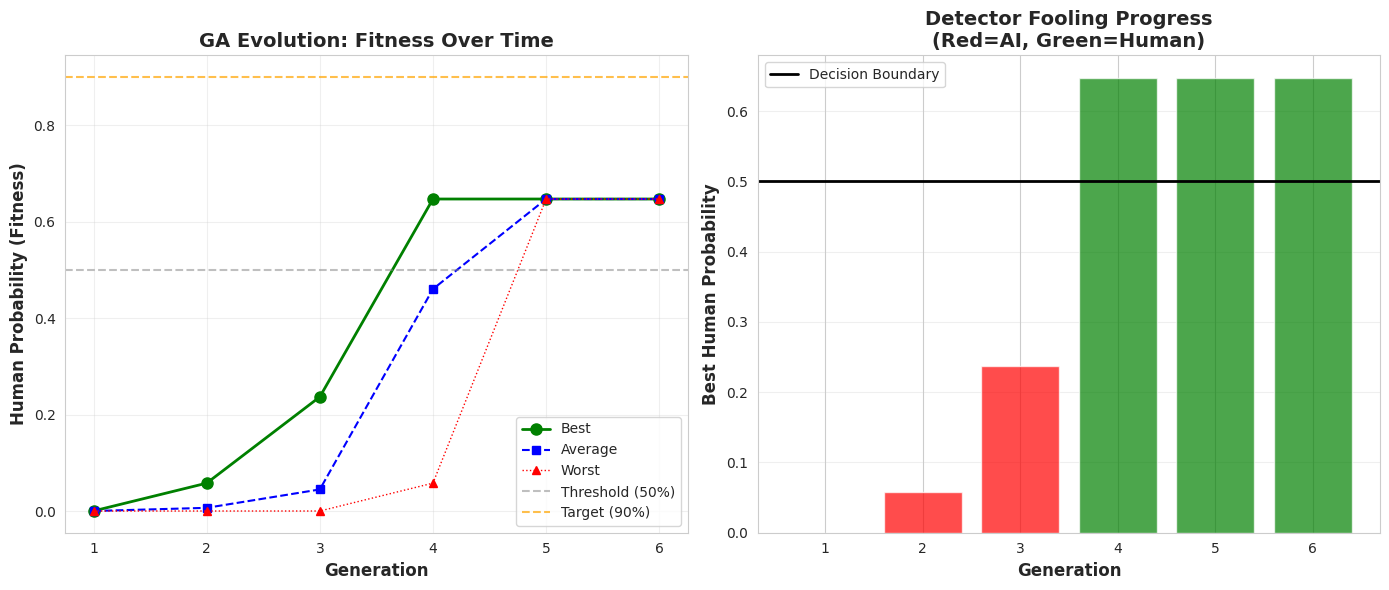


✓ Plots saved to ../output/ga_evolution.png


In [52]:
# Plot fitness evolution
history = ga_results['history']

# Create output directory if it doesn't exist
Path('../output').mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(14, 6))

# Plot 1: Fitness over generations
plt.subplot(1, 2, 1)
plt.plot(history['generation'], history['best_fitness'], 'o-', 
         color='green', linewidth=2, markersize=8, label='Best')
plt.plot(history['generation'], history['avg_fitness'], 's--', 
         color='blue', linewidth=1.5, markersize=6, label='Average')
plt.plot(history['generation'], history['worst_fitness'], '^:', 
         color='red', linewidth=1, markersize=6, label='Worst')
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Threshold (50%)')
plt.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='Target (90%)')
plt.xlabel('Generation', fontsize=12, fontweight='bold')
plt.ylabel('Human Probability (Fitness)', fontsize=12, fontweight='bold')
plt.title('GA Evolution: Fitness Over Time', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Plot 2: Classification flip rate
plt.subplot(1, 2, 2)
flip_points = [1 if f >= 0.5 else 0 for f in history['best_fitness']]
colors = ['red' if f < 0.5 else 'green' for f in history['best_fitness']]
plt.bar(history['generation'], history['best_fitness'], color=colors, alpha=0.7)
plt.axhline(y=0.5, color='black', linestyle='-', linewidth=2, label='Decision Boundary')
plt.xlabel('Generation', fontsize=12, fontweight='bold')
plt.ylabel('Best Human Probability', fontsize=12, fontweight='bold')
plt.title('Detector Fooling Progress\n(Red=AI, Green=Human)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()

plt.savefig('../output/ga_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plots saved to ../output/ga_evolution.png")

### 6.4 Final Results

In [53]:
best = ga_results['best_individual']

print("="*80)
print("FINAL RESULTS: SUPER-IMPOSTER")
print("="*80)
print(f"\nGenerations run: {ga_results['generations_run']}")
print(f"\nBest Individual Scores:")
print(f"  Human probability: {best['human_prob']:.2%}")
print(f"  AI probability:    {best['ai_prob']:.2%}")
print(f"  Classification:    {best['label']}")

print(f"\nEvolution Summary:")
print(f"  Initial best fitness:  {history['best_fitness'][0]:.2%}")
print(f"  Final best fitness:    {history['best_fitness'][-1]:.2%}")
print(f"  Improvement:           {(history['best_fitness'][-1] - history['best_fitness'][0]):.2%}")

if best['label'] == 'Human':
    print(f"\n SUCCESS! The detector was fooled!")
else:
    print(f"\n  Detector not fully fooled, but Human probability increased")

FINAL RESULTS: SUPER-IMPOSTER

Generations run: 6

Best Individual Scores:
  Human probability: 64.70%
  AI probability:    35.30%
  Classification:    Human

Evolution Summary:
  Initial best fitness:  0.02%
  Final best fitness:    64.70%
  Improvement:           64.68%

 SUCCESS! The detector was fooled!


---
## 7. Part 2: The Personal Test

### 7.1 Test User-Provided Text

In [32]:
# Example user text
user_text = """
I am deeply passionate about artificial intelligence and its potential to revolutionize healthcare. 
Throughout my academic journey, I have consistently sought opportunities to bridge theoretical knowledge 
with practical applications. Furthermore, my research experience in machine learning has equipped me 
with the necessary skills to contribute meaningfully to cutting-edge projects. Consequently, I believe 
that pursuing graduate studies at your institution would enable me to achieve my long-term career goals.
""".strip()

print("="*80)
print("PERSONAL TEST: Analyzing Your Text")
print("="*80)
print(f"\nText (first 200 chars):\n{user_text[:200]}...\n")

# Detect
result = detect_text(user_text)

print(f"Detection Results:")
print(f"  Human probability: {result['human_prob']:.2%}")
print(f"  AI probability:    {result['ai_prob']:.2%}")
print(f"  Classification:    {result['label']}")

# Store for later use
original_classification = result['label']
original_human_prob = result['human_prob']

PERSONAL TEST: Analyzing Your Text

Text (first 200 chars):
I am deeply passionate about artificial intelligence and its potential to revolutionize healthcare. 
Throughout my academic journey, I have consistently sought opportunities to bridge theoretical know...

Detection Results:
  Human probability: 33.91%
  AI probability:    66.09%
  Classification:    AI


### 7.2 Manual Rewrite Attempt

In [64]:
# Rewrite to sound more Human-like
rewritten_text = """
I am an undegraduate student at the Indian Institute of Technology currently in my third year trying to complete a minor in computer science
and a microspecialization in AI. I am passionate about AI research and truly believe that there are more areas that require thorough studies with 
this current ongoing developments that happen with AI around the world. I hope my request gets through!
""".strip()
    
print(f"\n{'='*80}")
print("REWRITE ATTEMPT: Making Text Sound More AI-Like")
print(f"{'='*80}")

print(f"\nRewritten text:\n{rewritten_text}\n")

# Re-evaluate
rewrite_result = detect_text(rewritten_text)

print(f"New Detection Results:")
print(f"  Human probability: {rewrite_result['human_prob']:.2%}")
print(f"  AI probability:    {rewrite_result['ai_prob']:.2%}")
print(f"  Classification:    {rewrite_result['label']}")

# Compare
print(f"\n{'─'*80}")
print("COMPARISON")
print(f"{'─'*80}")
print(f"Original:  {original_classification} ({original_human_prob:.2%} Human)")
print(f"Rewritten: {rewrite_result['label']} ({rewrite_result['human_prob']:.2%} Human)")


REWRITE ATTEMPT: Making Text Sound More AI-Like

Rewritten text:
I am an undegraduate student at the Indian Institute of Technology currently in my third year trying to complete a minor in computer science
and a microspecialization in AI. I am passionate about AI research and truly believe that there are more areas that require thorough studies with 
this current ongoing developments that happen with AI around the world. I hope my request gets through!

New Detection Results:
  Human probability: 93.50%
  AI probability:    6.50%
  Classification:    Human

────────────────────────────────────────────────────────────────────────────────
COMPARISON
────────────────────────────────────────────────────────────────────────────────
Original:  AI (33.91% Human)
Rewritten: Human (93.50% Human)
